In [22]:
import numpy as np
import pandas as pd
from numpy.linalg import inv, matrix_rank
from numpy import matmul
from scipy.stats import f
import matplotlib.pyplot as plt

from statsmodels.graphics.tsaplots import plot_acf
from arch import arch_model
from arch.univariate import GARCH, ConstantMean, Normal

## 3 b)

In [23]:
## Generates X and y data from inputted betas
def sim_data(betas, rows = 1000):
    xs = np.random.random((rows, len(betas)))
    y = (xs @ betas).reshape((rows,1)) +np.random.normal(0,1,(rows,1))
    return xs, y
    
## Make beta estimates.
def estimate_beta(xs, y):
    est = inv(xs.T @ xs) @xs.T @ y
    return est


## Makes a restriction matrix and the associated r vector.
def make_R_r(*args, betas):
    R = np.zeros((len(args), len(betas)))
    for idx,arg in enumerate(args):
        R[idx, arg] = 1
    r = (R @ betas).reshape((len(args),1))
    return R, r


## Calculates the F statistics
def f_stat(R, betas, xs, r, y):
    d = matrix_rank(R)
    #print(d)
    n = len(xs)
    K = len(betas)
    e = y - xs @ betas
    #print(e.shape)
    upper = ((R @ betas - r).T @ inv(R @ inv(xs.T @ xs) @ R.T) @ (R@betas -r))/d
    #print(upper)
    sample_var = (e.T @ e)/(n-K)
    #print(sample_var)
    F = upper/sample_var
    return [F, d, n-K]


## test that reject of accept the H0
def test(F,df1, df2, alpha = 0.05):
    crit = f.ppf(1-alpha, df1, df2)
    if F <= crit:
        print('Accept H0')
    else:
        print('Reject H0')
    return crit


## Puts many of the functions together and prints information
def sim(betas, R, r, res = True): 
    xs,y = sim_data(betas)
    beta_est = estimate_beta(xs,y)
    F, df1, df2 = f_stat(R, beta_est, xs, r, y)
    if res == True:
        crit = test(F, df1, df2)
        print(f'{'-'*60}')
        print(f'Critical value: {round(crit, 3)}')
        print(f'F: {round(F[0][0],3)}')
        print(f'beta estimates: {[n for n in beta_est]}')
        print(f'True betas: {[n for n in betas]}')
    else:
        crit = f.ppf(1-0.05, df1, df2)
    return crit, F
    

In [24]:
## Loops over a test simulation "iter" times. Counts times rejected.
def loop(betas,R, r, iter = 1000):
    n = 0
    reject = 0
    for i in range(iter):
        crit, F = sim(betas, R, r, res=False)
        if F>crit:
            reject += 1
        else:
            pass
        n += 1
    return reject, n

In [25]:
## create betas and restriction matrices for the datasets
a = np.array([1,5,3,8]).reshape((4,1))
R_a, r_a = make_R_r(1,3, [1,2,3], betas=a)

b = np.array([2,4,1,9]).reshape((4,1))
R_b, r_b = make_R_r(1,2, [1,3], betas=b)

c = np.array([1,2,1,2]).reshape((4,1))
R_c, r_c = make_R_r([1,2], 0, betas=c)

d = np.array([1,5,2,8,4]).reshape((5,1))
R_d, r_d = make_R_r([1,2], 0, betas=d)

test_sets = [(a, R_a, r_a), (b, R_b, r_b), (c, R_c, r_c), (d, R_d, r_d)]
i = 1
# iterate over the different generated data
for betas, R, r in test_sets:
    rej, n = loop(betas, R,r)
    print(f'Test {i}')
    print(f'True beta values {list(betas)}')
    print(f'Rejected tests: {rej}')
    print(f'Out of: {n}')
    print(f'{round(rej/n *100,2)}% of tests were rejected at level 0.05')
    print(f'{'-'*60}')
    i += 1

Test 1
True beta values [array([1]), array([5]), array([3]), array([8])]
Rejected tests: 53
Out of: 1000
5.3% of tests were rejected at level 0.05
------------------------------------------------------------
Test 2
True beta values [array([2]), array([4]), array([1]), array([9])]
Rejected tests: 49
Out of: 1000
4.9% of tests were rejected at level 0.05
------------------------------------------------------------
Test 3
True beta values [array([1]), array([2]), array([1]), array([2])]
Rejected tests: 61
Out of: 1000
6.1% of tests were rejected at level 0.05
------------------------------------------------------------
Test 4
True beta values [array([1]), array([5]), array([2]), array([8]), array([4])]
Rejected tests: 63
Out of: 1000
6.3% of tests were rejected at level 0.05
------------------------------------------------------------


## 3 c) 

In [26]:
## create a list for a range of different b1 values
betas_func = lambda b1: np.array([b1,5,3,8]).reshape((4,1))
b1s = np.linspace(-0.8, 0.8)
betas = [betas_func(b) for b in b1s]

R, r = make_R_r(0, betas = betas_func(0))
rejected = []
for i in betas:
    rej, n = loop(i, R, r)
    rejected.append(rej/1000)

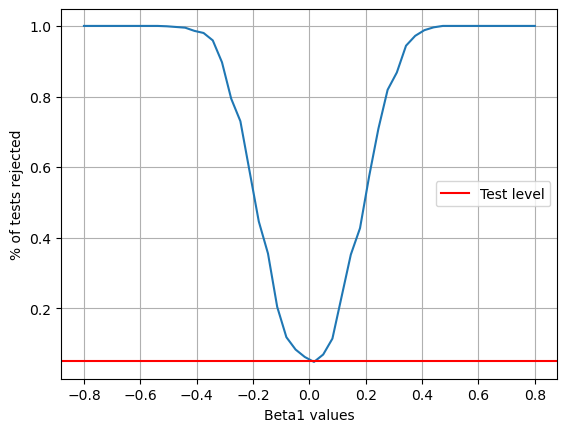

In [27]:
plt.plot(b1s, rejected)

plt.xlabel('Beta1 values')
plt.ylabel('% of tests rejected')
plt.axhline(0.05, color = 'red', label = 'Test level')

plt.grid(True)
plt.legend()
plt.show()

---------

## 4 a)

In [28]:
sp_df = pd.read_csv('SP500.csv')

# Drop rows with value '.'
df = sp_df.drop(sp_df[sp_df['SP500']== '.'].index)

In [29]:
## Change the data into float and calculate log return
values = df['SP500'].astype(float)
returns = (100*(np.log(values.shift()) - np.log(values)))[1:]


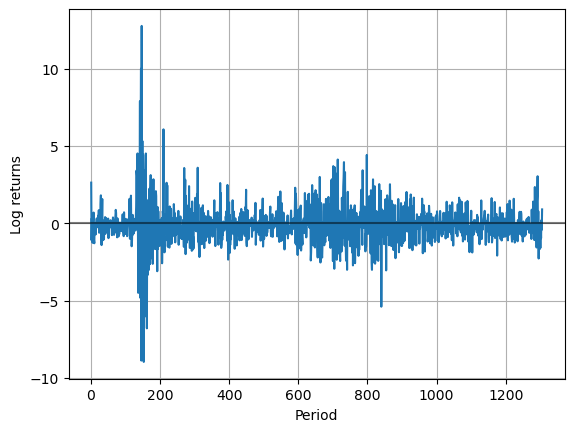

In [30]:
plt.plot(returns)

plt.axhline(0,0,1,color='black', alpha=0.5)

plt.ylabel('Log returns')
plt.xlabel('Period')
plt.grid(True)
plt.show()

Text(0, 0.5, 'Correlation Coefficient')

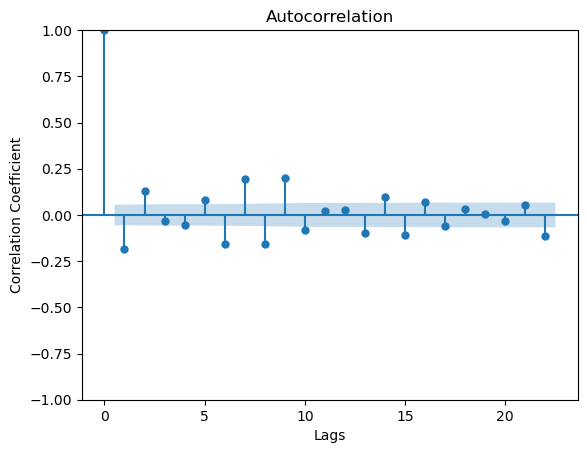

In [31]:
x = plot_acf(returns, lags=22)
plt.xlabel('Lags')
plt.ylabel('Correlation Coefficient')

## 4 b)

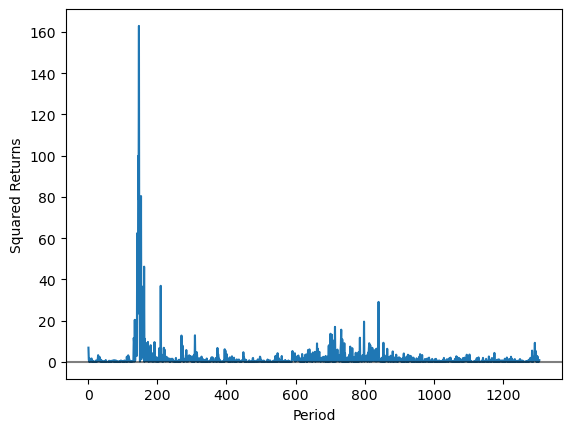

In [32]:
squared = returns**2

plt.plot(squared)
plt.xlabel('Period')
plt.ylabel('Squared Returns')
plt.axhline(0,0,1,color='black', alpha=0.5)

plt.show()

Text(0, 0.5, 'Correlation Coefficient')

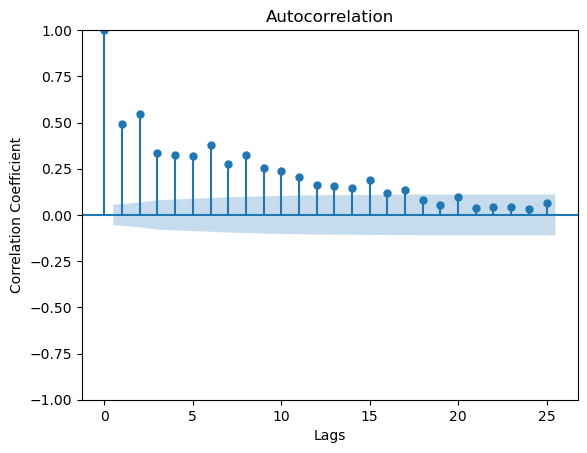

In [33]:
y = plot_acf(squared, lags=25)

plt.xlabel('Lags')
plt.ylabel('Correlation Coefficient')

## 4 d)

In [36]:
r = (np.log(values).diff() * 100)[1:]
model = arch_model(r)
model = ConstantMean(r)
model.volatility = GARCH(1, 0, 1)
model.distribution = Normal()

res = model.fit()

Iteration:      1,   Func. Count:      6,   Neg. LLF: 8137.141795224619
Iteration:      2,   Func. Count:     16,   Neg. LLF: 5382.508991237986
Iteration:      3,   Func. Count:     25,   Neg. LLF: 2759.6962150952813
Iteration:      4,   Func. Count:     33,   Neg. LLF: 5431.071182192057
Iteration:      5,   Func. Count:     39,   Neg. LLF: 1804.642730139355
Iteration:      6,   Func. Count:     45,   Neg. LLF: 1804.5099387890903
Iteration:      7,   Func. Count:     50,   Neg. LLF: 1804.5045500291344
Iteration:      8,   Func. Count:     55,   Neg. LLF: 1804.5045200927361
Iteration:      9,   Func. Count:     60,   Neg. LLF: 1804.5045189449675
Iteration:     10,   Func. Count:     64,   Neg. LLF: 1804.5045189450093
Optimization terminated successfully    (Exit mode 0)
            Current function value: 1804.5045189449675
            Iterations: 10
            Function evaluations: 64
            Gradient evaluations: 10


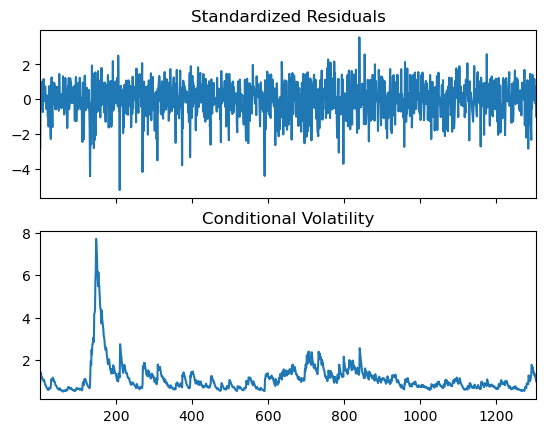

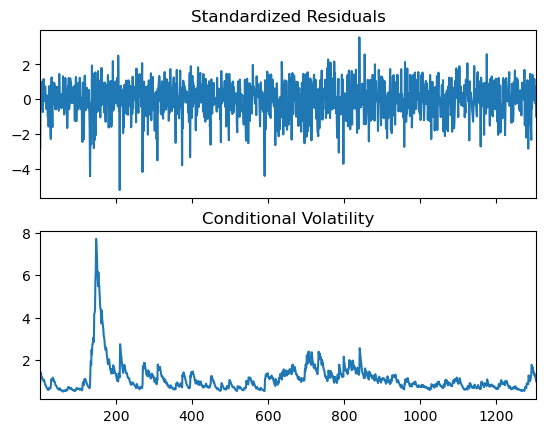

In [37]:
res.plot()